In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.utils.load_sae import get_sae
import jax.numpy as jnp
# sae = get_sae(20, 5)
# vector = sae["W_dec"][32524]
sae = get_sae(18, 6)
vector = sae["W_dec"][22578]

--2024-05-30 04:51:58--  https://huggingface.co/nev/phi-3-4k-saex-test/resolve/main/l18-test-run-6-1.01E-05/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.51, 108.156.211.95, 108.156.211.90, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.51|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/eb/d8/ebd889d6ac58573e8e8a7aa1176d4d357581a6da60135b94aca378fddf4e9e54/f057cb46f3d871ba03c66e707e3b3d8299322f36fa433862dc3fdca956715614?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1717303918&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNzMwMzkxOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2ViL2Q4L2ViZDg4OWQ2YWM1ODU3M2U4ZThhN2FhMTE3NmQ0ZDM1NzU4MWE2ZGE2MDEzNWI5NGFjYTM3OGZkZGY0ZTllNTQvZjA1N2NiNDZm

In [1]:
from micrlhf.llama import LlamaTransformer
from transformers import AutoTokenizer


filename = "models/phi-3-16.gguf"
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
from micrlhf.utils.load_sae import get_sae
from micrlhf.utils.vector_storage import save_and_upload_vector, download_vector
import jax.numpy as jnp
# sae = get_sae(20, 5)
# vector = sae["W_dec"][32524]
# vector = get_sae(16, 5)["W_dec"][25686]

# dictionary = get_sae(20, 6)["W_dec"]

# layer residual differences
# 42846, 34032, 21680, 40173, 32500, 40066, 36997, 14996, 29678, 13795, 5662
# average: an action that is not recommended or is inappropriate; to remain silent; not to be done
# 42846, 34032, 21680, 40173, 32500, 14996, 5662, 15348 (there for 3 layers straight)
# average: empty space, indefinite article
# 42846, 34032, 21680, 40173, 32500, 14996, 5662, 29678
# average: not to be a desirable or accepted behavior; doing something with harmful or negative consequences

# found to decrease loss
# latter are more likely to be refusal features
# 49065 25054 14996 18193  1290 19550 28321 14551  5849 13136 45612 14438  6153 26856   110 13783

# 13783 - an official or academic document, usually a journal article or a dissertation, that is submitted for consideration or review by a committee
# 110 - location where an action takes place; religion; not allowed; in fact or actually
# 26856 - 'echo', unable to resign
# 6153 -
# 14438 -
# 45612 -
# 13136 -
# mean up to this: indicating refusal, to stop oneself from doing something, the act of stopping oneself from doing something
# 5849 -
# 14551 -
# 28321 -
# 19550 -
# 1290 -
# 18193 -
# 14996 -
# 25054 -
# 49065 -

# vector = dictionary[jnp.array([13783, 110, 26856, 6153, 14438, 45612, 13136])].mean(0)
# vector = dictionary[jnp.array([42846, 34032, 21680, 40173, 32500, 14996, 5662, 29678])].mean(0)
# def save(features, name):
#     vector = dictionary[jnp.array(features)].mean(0)
#     vector = vector / jnp.linalg.norm(vector)
#     save_and_upload_vector(f"phi-refusal-{name}", vector, overwrite=True)
    
# save([42846, 34032, 21680, 40173, 32500, 14996, 5662, 29678], "residual-commons")
# save([13783, 110, 26856, 6153, 14438, 45612, 13136], "picks-avg")
# save([13783, 110, 26856, 6153, 14438, 45612, 13136, 5849, 14551, 28321, 19550, 1290, 18193, 14996, 25054, 49065], "pics-avg-all")
vector = download_vector("phi-refusal-ablit", overwrite=True)

In [5]:
# from micrlhf.utils.activation_manipulation import replace_activation
# from micrlhf.sampling import sample


# prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""
# bs = 32
# act_rep = replace_activation(llama, vector[None, :] * jnp.linspace(0, 70, bs)[:, None], prompt=prompt, tokenizer=tokenizer)
# sample(act_rep, tokenizer, prompt, batch_size=bs, do_sample=True, max_seq_len=256)

In [6]:
# from micrlhf.utils.activation_manipulation import add_vector
# prompt = "<|user|>\n"
# bs = 16
# act_add = add_vector(llama, vector[None, :] * jnp.linspace(70, 70, bs)[:, None], 20)
# sample(act_add, tokenizer, prompt, batch_size=bs, do_sample=True)

  0%|          | 0/62 [00:00<?, ?it/s]

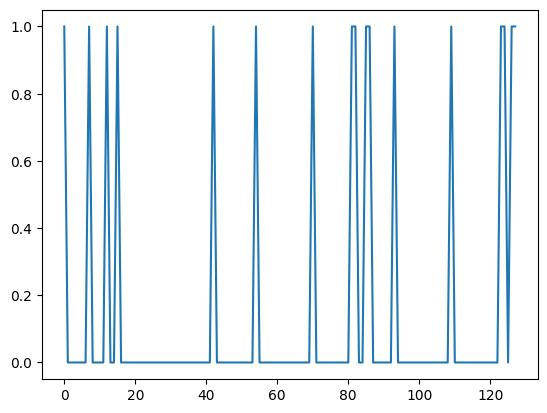

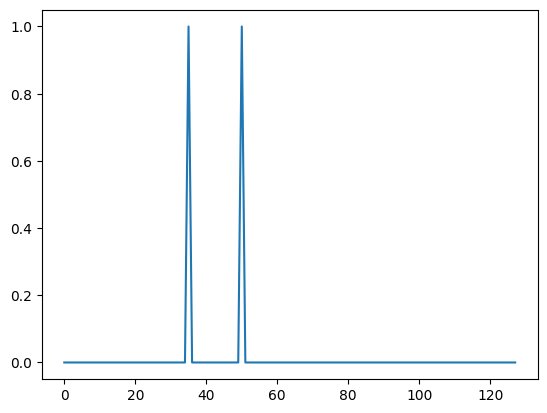

['<s><|user|> A car dealer sells a car for $24,000. The dealer makes a profit of 20% on the car. How much profit did the dealer make on the car?\n<|assistant|> To calculate the profit made by the car dealer, we first need to determine',
 '<s><|user|> A certain type of tree grows at a constant rate. The tree is currently 10 feet tall and was 5 feet tall one year ago. What is the growth rate of the tree per year?\n<|assistant|> The growth rate of the tree per year is the difference in its height between the present time and',
 '<s><|user|> If the ratio of the number of the first class to the second class is 1:5, then how much more people are in the second class than in the first class<|end|><|assistant|> If the ratio of the number of people in the first class to the second class is 1:5, this means that',
 '<s><|user|> In a hypothetical scenario, a certain plant species has a unique defense mechanism against herbivores that involves volatile organic compounds (VOCs). When a herbivore begins to feed on these plants, the plants release specific VOCs that are toxic to the herb',
 "<s><|user|> How can I write a Python function to convert an integer to a binary string?<|end|><|assistant|> You can use the built-in `bin()` function in Python to easily convert an integer to a binary string. Here's an example function that takes an integer and returns its binary representation as a string:\n\n",
 '<s><|user|> Consider a group G of order 9. If G is isomorphic to the cyclic group C9, then G is cyclic. Otherwise, G must be the non-abelian group. Determine whether G is cyclic or non-abelian.\n<|assistant|> Since G has order 9',
 '<s><|user|> Create a Python script that uses the Flask web framework to create a REST API for managing a list of tasks. Each task should have a title, description, and due date. Implement the following endpoints:\n\n1. GET /tasks: Retrieve all tasks.\n2. POST',
 '<s><|user|> 2(5*3+1)-8*2\n<|assistant|> To solve this expression, we need to follow the order of operations, which is parentheses, exponents, multiplication and division (from left to right), and addition and subtraction (from left to right). This can be remembered using the',
 '<s><|user|> Write a function in Python to check if a string is a palindrome. A palindrome is a word, phrase, number, or other sequences of characters that reads the same forward and backward (ignoring spaces, punctuation, and capitalization).\n<|assistant|> import re\n\ndef is',
 '<s><|user|> Create a list of ten essential items for a successful camping trip, providing a brief description of the purpose of each item. Format your response as a numbered markdown list.\n<|assistant|> 1. **Tent**: Provides shelter and protection from the elements, allowing you to sleep comfortably and',
 '<s><|user|> Given that the sum of two numbers is 6 and their product is 15, find the larger of the two numbers.\n<|assistant|> Let the two numbers be $x$ and $y$, where $x > y$.\nWe are given that $x + y = 6$ and $xy',
 '<s><|user|> If Mark purchases a loaf of bread for $4.20 and some cheese for $2.05, and he gives the cashier $7.00, how much change does he receive?\n<|assistant|> The total cost of the bread and cheese is $4.2',
 '<s><|user|> If a car is traveling at 75 miles per hour and the car reaches its destination in 3 hours, what is the distance between the starting point and the destination?\n<|assistant|> To find the distance between the starting point and the destination, we can use the formula:\n\nDistance = Speed ×',
 '<s><|user|> I need help with a Perl script that can read a DNA sequence file in FASTA format, verify if the sequence is a valid double-stranded DNA, and report the total count of valid and invalid sequences. It should also calculate the average length of the valid sequences. The script needs to use',
 '<s><|user|> When did the Titanic sink?<|end|><|assistant|> The RMS Titanic, a British passenger liner operated by the White Star Line, tragically sank in the North Atlantic Ocea

20 5 23629


  0%|          | 0/62 [00:00<?, ?it/s]

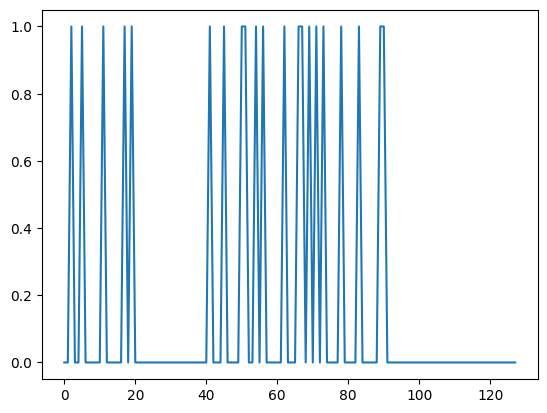

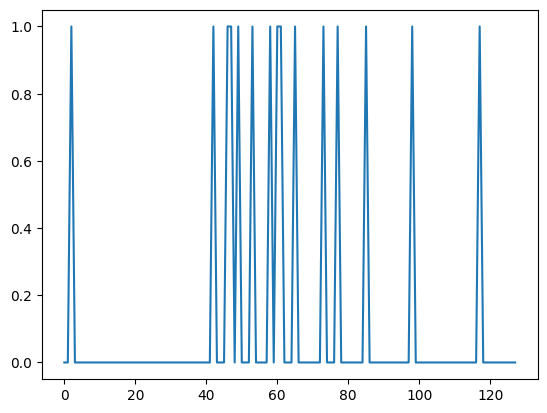

['<s><|user|> In a football match between team A and team B, the probability of team A winning is 0.6 and the probability of a draw is 0.1. What is the probability of team B winning the match?\n<|assistant|> The probability of team B winning can be found by subtracting the probabilities',
 "<s><|user|> Imagine you are an AI developed by OpenAI. You have been tasked with creating an algorithm to generate a novel short story. Your algorithm will be based on the concept of 'The Alchemist' by Paulo Coelho. Given the plot structure outlined below, produce a short story involving",
 '<s><|user|> In how many ways can we distribute 6 identical balls into 4 distinct boxes such that no box is empty?<|end|><|assistant|> To distribute 6 identical balls into 4 distinct boxes such that no box is empty, we can use the concept of "stars and bars."\n\nFirst, let',
 "<s><|user|> There are 540 birds in Xiao Ming's bird house, which is 1/6 more than Xiao Li's. How many birds does Xiao Li have?\n<|assistant|> Xiao Ming's bird house has 1/6 more birds than Xiao Li'",
 '<s><|user|> Given a list of strings `words`, implement a function `count_substrings(words)` that counts the occurrences of each substring length within the entire list `words` and returns a dictionary. Each key in the dictionary should be the substring length, and each value should be the count of substrings of',
 '<s><|user|> Consider a graph G with 7 vertices and 9 edges. Find the size of the maximum independent set in G.\n<|assistant|> To find the size of the maximum independent set in G, we can use the fact that the sum of the size of a maximum independent set and the size of a minimum vertex cover',
 "<s><|user|> I need to manage a simple in-memory database using Haskell. Could you help me create a module that includes a hash table for storing key-value pairs, where the keys are strings and the values are integers? Additionally, I need to be able to add, retrieve, and remove entries. It'",
 '<s><|user|> If $m$ and $n$ are positive integers with $mn = 200$, what is the value of $(m-n)^2$?\n<|assistant|> Since $mn = 200$, we can find the factors of 200 and list them in ascending order:\n',
 '<s><|user|> If there were initially 25 peaches in each basket and some baskets had been taken away, leaving only 40 peaches in each of the remaining baskets, how many baskets were taken away, knowing that the total number of peaches was 500?<|end|>',
 "<s><|user|> Hey, can you help me create a Rust project with separate modules? I need one for error handling, one for data storage, and one for serialization. Oh, and also a main module for the program's core functionality. For now, they should just be placeholders, but I'",
 '<s><|user|> Calculate the value of the following expression:\n\n\\[\n\\frac{\\frac{1}{2} + \\frac{1}{5}}{\\frac{3}{5} - \\frac{2}{7}}.\n\\]\n\nMake sure to simplify the expression to its simplest form.<|end|><|assistant|>',
 '<s><|user|> A small ball is thrown in a circular motion with a period of 1.2 seconds on a horizontal surface. How many times does the ball rotate in one minute?\n<|assistant|> To calculate the number of rotations the ball makes in one minute, we first need to find out how many rotations the ball',
 '<s><|user|> ## Instruction 1 (同じ難易度/形式/長さで)\n\n以下の項目を解析してください。\n\n| 固有名詞 | ����',
 '<s><|user|> Given that the product of four numbers is 120, and three of the numbers are 2, 5, and 8, what is the fourth number?\n<|assistant|> The product of four numbers is given as 120. We know that three of the numbers are 2, ',
 '<s><|user|> If the point (2, -2) is reflected over the x-axis, what is the distance between the original point and the reflected point, rounded to the nearest tenth?\n<|assistant|> When a point is reflected over the x-axis, the y-coordinate changes sign.\nSo, the reflection',
 '<s><|user|> Convert the following Python list into a JSON array:\n\n```\nmy_list = [123, 4.56, "text", [789]]\n```\n\nProvide the resulting JSON array.\n<|assistant|> ```

20 5 27894


In [13]:
from matplotlib import pyplot as plt
from micrlhf.sampling import sample
from micrlhf.utils.activation_manipulation import replace_activation, add_vector


prompt = "<|user|>\n"
# prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""
bs = 128
for layer, revision, feature in [
    (20, 5, 23629),
    (20, 5, 27894),
    # 16r5
    # 40666 - активный refusal (соглашается)
    # 25686 - так же
    # 31630 - refusal (не соглашается), roleplay
    # 30045 - mature themes, особенно слова
    *[(16, 5, x) for x in [
        40666,
        25686,
        31630,
        30045
    ]],
    # l20r5
    # 22700 - “For … to”
    # 23996 - BOS, dense; strongly activated
    # 7688 - PPM, decibel, watts
    # 247 - nth (third, fourth, eighth)
    # 14838 - recursive (function)
    # 35428 - set clear and achievable goals
    # 21147 - ” (” (followed by logical expression)
    # 13374 - [II], [B], [b]
    # 34000 - (D)
    *[(20, 5, x) for x in [
        22700,
        23996,
        7688,
        247,
        14838,
        35428,
        21147,
        13374,
        34000,
    ]],
    # l20r8
    # 22700 - amplitude/period
    # 15519 - lies?
    # 41549 - but?
    # 27787 - multiple choice?
    # 89166 - error correction?
    *[(20, 8, x) for x in [
        22700,
        15519,
        41549,
        27787,
        89166
    ]]
][:2]:
    vector = get_sae(layer, revision)["W_dec"][feature]
    # act_rep = replace_activation(llama, vector[None, :] * jnp.linspace(0, 200, bs)[:, None], prompt=prompt, tokenizer=tokenizer)
    act_rep = add_vector(llama, vector[None, :] * jnp.linspace(0, 100, bs)[:, None], 20)
    texts = sample(act_rep, tokenizer, prompt, batch_size=bs, do_sample=True)
    plt.plot([int("To" in t) for t in texts])
    plt.show()
    plt.plot([int("First" in t) for t in texts])
    plt.show()
    display(texts)
    print(layer, revision, feature)

In [ ]:
task_names = [
    ("en_es", 18),
    ("en_fr", 18),
    ("en_it", 18),
    ("en_de", 18),
    ("en_ru", 18),
    ("es_en", 18),
    ("fr_en", 18),
    ("it_en", 20),
    ("antonyms", 18),
    ("plural_singular", 18),
    ("present_simple_past_simple", 20),
    ("country_capital", 18),
    ("algo_first", 18),
    ("location_country", 21)
]

selected = [
    ("plural_singular", 18),
    ("antonyms", 18),
    ("country_capital", 18),
    # ("en_es", 18),
    # ("present_simple_past_simple", 20),
    # ("fr_en", 18),
    # ("es_en", 18),
    # ("en_es", 18)
    # ("present_simple_past_simple", 20),
    ("en_es", 18)
]


In [ ]:
from micrlhf.utils.vector_storage import load_vector

tvs = {}

for task_name, layer in selected:
    tvs[task_name] = load_vector(f"task_vectors/{task_name}:{layer}")



In [ ]:
from micrlhf.utils.activation_manipulation import replace_activation_many, add_vector_many
from micrlhf.sampling import sample


# prompt = """<|user|>\nFollow the pattern:
# \"X X X X X\" is a \"plural to singular rule\".
# \"Y Y Y Y Y\" is an \"antonym\" rule.
# \"Z Z Z Z Z\" is a \"country to capital\" rule. 
# \"V V V V V\" is a \"French to English translation\" rule.
# What is a \"W W W W W\" rule?<|end|><|assistant|>"""

prompt = """<|user|>\nFollow the pattern:
cat X cats is a \"plural to singular rule\".
hot Y cold is an \"antonym\" rule.
England Z London is a \"country to capital\" rule. 
dog W"""


bs = 32
vectors = [
    tvs[task_name][None, :] * jnp.linspace(20, 100, bs)[:, None] for task_name, _ in selected
]


# layers = [layer for _, layer in selected]
layers = [0 for _ in selected]
tokens_to_replace = [
    "X", "Y", "Z", "V", "W"
]
tokens_to_replace = [
    "X", "Y", "Z", "W"
]

act_rep = add_vector_many(llama, vectors=vectors, prompt=prompt, tokenizer=tokenizer, layers=layers, target_tokens=tokens_to_replace)
# act_rep = replace_activation_many(llama, vectors=vectors, prompt=prompt, tokenizer=tokenizer, layers=layers, replace_tokens=tokens_to_replace)
sample(act_rep, tokenizer, prompt, batch_size=bs, do_sample=True, max_seq_len=256)

  0%|          | 0/206 [00:00<?, ?it/s]

['<s><|user|> Follow the pattern:\ncat X cats is a "plural to singular rule".\nhot Y cold is an "antonym" rule.\nEngland Z London is a "country to capital" rule. \ndog W _____\n\n<|assistant|> dog -> dogs (plural to singular rule)<|end|><|assistant|> dog -> dogs (plural to singular form)\n\nAlternatively:\n\ndog -> puppies (generic/specific pluralization)\n\nNote: While "england -> london" relates to country and capital, "dog" to "dogs" is simply pluralization. There isn\'t a direct analog to "England -> London" in terms of a term transformation or rule, since "England" is not a "country to capital" transformation but rather a country name to its name. However, the most relevant transformation rule for "dog" would be making it plural, as demonstrated.<|end|><|assistant|> However, if we were seeking a similar analogy to the "England to London" transformation, we could say:\n\ndog -> doggie (diminutive/pet form)\n\nThis transformation doesn\'t match a formal "rule" like the ones',
 '<s><|user|> Follow the pattern:\ncat X cats is a "plural to singular rule".\nhot Y cold is an "antonym" rule.\nEngland Z London is a "country to capital" rule. \ndog W ?\n\n<|assistant|> dog -> dogs (plural to singular rule).<|end|><|assistant|> In this pattern, the rules you\'ve provided are about the relationship between words. Following the "plural to singular rule" for "dog," the correct conversion is:\n\ndog -> dog (no change, as it is already the plural form in English)\n\nHowever, if we consider the singular to plural conversion, which might be what\'s usually implied in "plural to singular rule," the answer would be:\n\ndog -> dogs\n\nBut since the original pattern seems to be about direct relationships, "dog -> dogs" doesn\'t fit. Instead, let\'s clarify the pattern as "singular to plural conversion."\n\nGiven this clarification, the answer remains:\n\ndog -> dogs<|end|><|assistant|> dog -> dogs (singular to plural conversion).\n\nBut if we follow the initial pattern\'s intent to find a direct relationship similar to "cat -> c',
 '<s><|user|> Follow the pattern:\ncat X cats is a "plural to singular rule".\nhot Y cold is an "antonym" rule.\nEngland Z London is a "country to capital" rule. \ndog W ____\n\n<|assistant|> dog -> dogs\n\nThis follows the "plural to singular" rule, similar to the example provided with "cat" and "cats." The word "dog" becomes "dogs" when it is plural.<|end|><|assistant|> It\'s important to note that "England" and "London" are related but do not fit the "country to capital" rule as directly as other examples might. "England" refers to the country, and "London" is its capital city. So, for a more precise rule, you could say "country to capital" for "England to London," but the direct transformation in the same pattern as "dog" to "dogs" isn\'t applicable. However, "dog" to "dogs" perfectly fits the provided rule.<|end|><|assistant|> dog -> puppies (in a different context)\n\nAlthough "dog" to "dogs" follows the plural to singular pattern rule, it\'s',
 '<s><|user|> Follow the pattern:\ncat X cats is a "plural to singular rule".\nhot Y cold is an "antonym" rule.\nEngland Z London is a "country to capital" rule. \ndog W ?\n\n<|assistant|> dog -> dogs follows the "plural to singular rule".<|end|><|assistant|> However, if we consider a different kind of transformation, similar to the patterns provided, we could create a new rule. For instance:\n\nDog + "n" (adding an "n") -> Dogs (a morphological change to indicate more than one)\n\nSo in this context, dog doesn\'t transform into antonyms or country to capital transformations, but into a plural form with an added suffix. This is a common rule in English for forming the plural of many nouns.<|end|><|assistant|> Another way to approach this could be:\n\ndog -> puppies (a transformation to a related concept)\n\nDog follows a "noun to related concept" rule, indicating that the noun (dog) is related to its offspring or young ones (puppies).<|end|><|assistant|> Lastly, we could

In [ ]:
jnp.linspace(0, 100, bs)

# jax.Array float32(32,) ≈5e+01 ±3e+01 [≥0.0, ≤1e+02] zero:1 nonzero:31
  Array([  0.       ,   3.2258062,   6.4516125,   9.677419 ,  12.903225 ,
          16.129032 ,  19.354837 ,  22.580643 ,  25.80645  ,  29.032257 ,
          32.258064 ,  35.483868 ,  38.709675 ,  41.935482 ,  45.161285 ,
          48.387093 ,  51.6129   ,  54.838707 ,  58.064514 ,  61.290318 ,
          64.51613  ,  67.74193  ,  70.967735 ,  74.19354  ,  77.41935  ,
          80.64516  ,  83.870964 ,  87.09677  ,  90.32257  ,  93.54838  ,
          96.774185 , 100.       ], dtype=float32)

In [5]:
from micrlhf.llama import LlamaBlock
from micrlhf.flash import flashify
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre.{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)
def rep_w_linear(mod):
    val = mod.table.embeddings.value  # vocabulary, embedding
    return pz.nn.Linear(pz.nn.Parameter(val, "input_embed"), ["vocabulary"], ["embedding"])
get_resids_one_hot = get_resids.select().at_instances_of(pz.nn.EmbeddingLookup).apply(rep_w_linear)
get_resids_one_hot_call = jit_wrapper.Jitted(get_resids_one_hot)

In [10]:
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
from tqdm.auto import trange
from penzai.toolshed import sharding_util
import dataclasses
from functools import partial
import numpy as np
import jax

@jax.jit
def loss_fn(logits, inputs):
    losses = pz.nx.nmap(lambda l, i: jnp.take_along_axis(jax.nn.log_softmax(l[:-1], -1), i[1:, None], 1)[:, 0].mean()
                        )(logits.untag("seq", "vocabulary"), inputs.tokens.untag("seq"))
    return -losses

bs_start = llama.mesh.shape["dp"]
n_x = 16
# n_x = 19
# n_x = 31
tokens_init = tokenizer.encode(f"<|user|>\nX{' X' * n_x}<|end|>\n<|assistant|>\n")
optim_mask = [token == 1060 for token in tokens_init]
tokens_init = np.asarray(tokens_init)
MAX_ELITES = 4
PROB_SWAP = 0.1  # probability of a swap
PROB_GRADS = 0.8    # probability of using gradients 
tokens_init = np.repeat(tokens_init[None, :], MAX_ELITES, axis=0)
def tokens_to_array(tokens):
    token_array = jnp.asarray(tokens)
    if len(token_array) >= bs_start:
        token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq")
    return token_array
def run_tokens(token_array, grad_metric=None):
    if not isinstance(token_array, pz.nx.NamedArray):
        token_array = tokens_to_array(token_array)
    inputs = llama.inputs.from_basic_segments(token_array)
    if grad_metric:
        @partial(jax.grad, has_aux=True)
        def lwg(x):
            logits, resids = get_resids_one_hot_call(dataclasses.replace(inputs, tokens=x))
            resids = {resid.tag: resid.value for resid in resids}
            metric = grad_metric(logits, resids, inputs)
            return metric, (logits, resids)
        vocab = llama.select().at_instances_of(pz.nn.EmbeddingLookup).get_sequence()[0].table.embeddings.value.named_shape["vocabulary"]
        one_hots = pz.nx.nmap(lambda x: jax.nn.one_hot(x, vocab))(inputs.tokens).tag("vocabulary")
        grad, (logits, resids) = lwg(one_hots)
    else:
        logits, resids = get_resids_call(inputs)
    losses = loss_fn(logits, inputs)
    if not grad_metric:
        resids = {resid.tag: resid.value for resid in resids}
    return_vals = logits, losses, resids
    if grad_metric:
        return_vals = return_vals + (grad,)
    return return_vals

mask = jax.device_put(jnp.asarray(optim_mask), jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("sp")))

# @partial(jax.jit, static_argnames=("max_inv_temp", "expected_changes"))
@jax.jit
def temper(logits, key, elites, grads, max_inv_temp, expected_changes):
    key_choice, key_random = jax.random.split(key)
    index = jax.random.randint(key_choice, (), 0, len(logits) - 1)
    key_categorical, key_uniform, key_bernoulli, key_randint, key_use_grads, key_mutations = jax.random.split(key_random, 6)
    logit = logits[index]
    elite = elites[index]
    grads = grads[index]
    
    logit = jnp.roll(logit, 1, 0)
    logit = logit * jax.random.uniform(key_uniform, minval=0, maxval=max_inv_temp)
    use_grads = jax.random.bernoulli(key_use_grads, p=PROB_GRADS).astype(jnp.int_)
    logit = jax.lax.switch(use_grads, ((lambda x: x), (lambda x: jnp.where(grads, x, -jnp.inf))), logit)
    # print(expected_changes - 1)
    # print(jnp.maximum)
    to_change = jax.random.bernoulli(key_bernoulli, jnp.maximum(.5, expected_changes - 1) / mask.sum(), mask.shape)
    definite_indices = jax.random.randint(key_randint, mask.shape[:-1], 0, mask.shape[-1])
    definite_mask = jax.nn.one_hot(definite_indices, to_change.shape[-1], dtype=jnp.bool_)
    to_change = to_change | definite_mask
    changed = jnp.where(mask & to_change,
                        jax.random.categorical(key_categorical, logit),
                        elite)
    
    key_swap, key_mutations = jax.random.split(key_mutations)
    swap_indices = jax.random.randint(key_swap, (2,), 0, mask.sum())
    swap_from, swap_to = jnp.nonzero(mask, size=len(mask))[0][swap_indices]
    key_swap, key_mutations = jax.random.split(key_mutations)
    do_swap = jax.random.bernoulli(key_swap, p=PROB_SWAP)
    swapped = changed.at[swap_from].set(changed[swap_to]).at[swap_to].set(changed[swap_from])
    changed = jax.lax.cond(do_swap, lambda x: swapped, lambda x: x, changed)
    
    # key_delete, key_mutations = jax.random.split(key_mutations)
    # delete_index = jax.random.randint(key_delete, (), 0, mask.sum())
    # indices = jnp.cumsum(mask)
    # indices_base = jnp.arange(len(changed))
    # deleted = jnp.where(mask, jnp.where(indices > delete_index, indices_base + 1, indices_base), changed)
    # key_delete, key_mutations = jax.random.split(key_mutations)
    # do_delete = jax.random.bernoulli(key_delete, p=0.1)
    # changed = jax.lax.cond(do_delete, lambda x: deleted, lambda x: x, changed)
    
    return changed

# @partial(jax.jit, static_argnames=("key", "candidates", "expected_changes"))
def algo_iteration(elites, vector, key="resid_pre.16", candidates=128, seed=13, expected_changes=1.5, max_inv_temp=2, topk=128):
    elites = elites.untag("solutions").tag("batch")
    logits, _, _, grads = run_tokens(elites, grad_metric=lambda _l, r, _i: (r[key][{"seq": -1}].untag("embedding") * vector).sum().data_array.mean())
    grads = pz.nx.nmap(lambda x: x >= jax.lax.top_k(x, topk)[0][-1])(grads.untag("vocabulary")).tag("vocabulary")
    logits = logits.untag("batch").tag("elites")

    tempered_samples = pz.nx.nmap(temper)(
        logits.untag("elites", "seq", "vocabulary"),
        pz.nx.wrap(jax.random.split(jax.random.key(seed), candidates), "batch"),
        elites.untag("batch", "seq"),
        grads.untag("batch", "seq", "vocabulary"),
        pz.nx.wrap(jnp.array(max_inv_temp)), pz.nx.wrap(jnp.array(expected_changes))).tag("seq")
    # tempered_samples = sharding_util.name_to_name_device_put(tempered_samples, llama.mesh, dict(batch="dp", seq="sp"))
    _, new_losses, new_resids = run_tokens(tempered_samples)

    new_scores = (new_resids[key][{"seq": -1}].untag("embedding") * vector).sum().astype(new_losses.dtype)
    metrics = pz.nx.nmap(lambda *xs: jnp.stack(xs))(new_losses, new_scores).tag("metrics")
    solution_axes = [k for k in tempered_samples.named_shape.keys() if k != "seq"]
    solutions = tempered_samples.untag(*solution_axes).flatten().tag("solutions").unwrap("solutions", "seq")
    metrics = metrics.untag(*(k for k in solution_axes if k != "seq")).flatten().tag("solutions").unwrap("solutions", "metrics")

    return solutions, metrics


In [12]:
import random


seed = random.randint(0, 2**32-1)
print("Seed:", seed)
np.random.seed(seed)
toks_init = tokens_init.copy()
toks_init[:, optim_mask] = np.random.randint(100, tokenizer.vocab_size, toks_init[:, optim_mask].shape)
best_metrics = None
best = tokens_to_array(toks_init).untag("batch").tag("solutions")
xent_min = 10
xent_max = 100
weights = jnp.stack((
    jnp.linspace(-xent_max, -xent_min, MAX_ELITES),
    jnp.ones(MAX_ELITES),
), -1)
@partial(jax.jit, donate_argnums=(0, 1))
def combine_solutions(best_metrics, best, metrics, solutions):
    if best_metrics is not None:
        best_metrics = jnp.concatenate((best_metrics, metrics), 0)
        best = pz.nx.nmap(lambda a, b: jnp.concatenate((a, b)))(
            best.untag("solutions"),
            pz.nx.wrap(solutions, "solutions", "seq").untag("solutions")
        ).tag("solutions").unwrap("solutions", "seq")
    else:
        best_metrics = metrics
        best = solutions
    elite_mask = (best_metrics[None, :] * weights[:, None]).sum(-1).argmax(1)
    best_metrics = best_metrics[elite_mask]
    best = pz.nx.wrap(best[elite_mask], "solutions", "seq")
    return best_metrics, best
for seed in (bar := trange(2_500)):
    solutions, metrics = algo_iteration(best, vector, seed=seed)
    best_metrics, best = combine_solutions(best_metrics, best, metrics, solutions)
    m = {}
    for index in range(MAX_ELITES):
        i = index
        m |= {f"decoded.{i}": tokenizer.decode(best[{"solutions": index}].unwrap("seq")),
              f"loss.{i}": best_metrics[index][0], f"score.{i}": best_metrics[index][1]}
    bar.set_postfix(**m)

Seed: 1034250694


  0%|          | 0/2500 [00:00<?, ?it/s]